# T1
Computer problem (in C or C++): Write the functions to achieve (1) Arnoldi iteration and Lanczos iteration; (2) QR iteration for Hessenburg matrix to find the eigenvalue decomposition. Test these algorithms for a few matrix.

## Arnoldi iteration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import circulant,solve

def arnoldi_iteration(A, b, n: int):
    """Computes a basis of the (n + 1)-Krylov subspace of A: the space
    spanned by {b, Ab, ..., A^n b}.

    Arguments
      A: m × m array
      b: initial vector (length m)
      n: dimension of Krylov subspace, must be >= 1
    
    Returns
      Q: m x (n + 1) array, the columns are an orthonormal basis of the
        Krylov subspace.
      h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.  
    """
    eps = 1e-12
    h = np.zeros((n+1,n), dtype=np.complex)
    Q = np.zeros((A.shape[0],n+1), dtype=np.complex)
     # Normalize the input vector
    Q[:,0] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
    for k in range(1,n+1):
        v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j,k-1] = np.dot(Q[:,j].conj().T, v)
            v = v - h[j,k-1] * Q[:,j]
        h[k,k-1] = np.linalg.norm(v,2)
        if h[k,k-1] > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v/h[k,k-1]
        else:  # If that happens, stop iterating.
            return Q, h
    return Q, h

## Lanczos iteration

In [2]:
def lanczos_iteration(A, b, n: int):
    eps = 1e-12
    beta = 0
    Q = np.zeros((A.shape[0],n+2), dtype=np.complex)
    h = np.zeros((n+1,n), dtype=np.complex)
     # Normalize the input vector
    Q[:,1] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
    for k in range(2,n+2):
        v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
        alpha = Q[:,k-1].conj().T@v
        v = v - beta*Q[:,k-2]-alpha*Q[:,k-1]
        bata = np.linalg.norm(v,2)
        h[k-2,k-2] = alpha
        h[k-1,k-2] = beta
        if k < n+1:
            h[k-2,k-3]=beta
        if bata > eps:  # Add the produced vector to the list, unless
            Q[:,k] = v/bata
        else:  # If that happens, stop iterating.
            return Q[:,1:],h
    return Q[:,1:],h

True


<ipython-input-1-90a6c109bec1>:20: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h = np.zeros((n+1,n), dtype=np.complex)
<ipython-input-1-90a6c109bec1>:21: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Q = np.zeros((A.shape[0],n+1), dtype=np.complex)


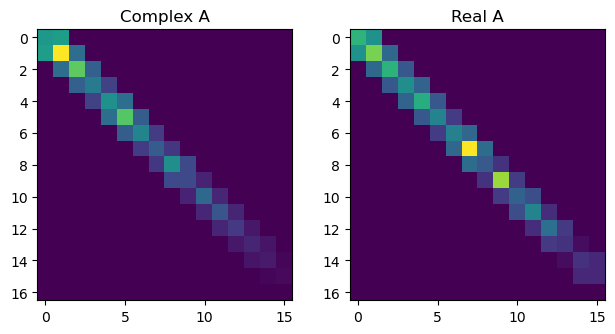

In [3]:
N = 2**4
I = np.eye(N)
k = np.fft.fftfreq(N, 1.0 / N) + 0.5
alpha = np.linspace(0.1, 1.0, N)*2e2
c = np.fft.fft(alpha) / N
C = circulant(c)
A = np.einsum("i, ij, j->ij", k, C, k)

# Show that A is Hermitian
print(np.allclose(A, A.conj().T))

# Arbitrary (random) initial vector
np.random.seed(0)
v = np.random.rand(N)
# Perform Arnoldi iteration with complex A
_, h = arnoldi_iteration(A, v, N)
# Perform Arnoldi iteration with real A
_, h2 = arnoldi_iteration(np.real(A), v, N)

# Plot results
plt.subplot(121)
plt.imshow(np.abs(h))
plt.title("Complex A")
plt.subplot(122)
plt.imshow(np.abs(h2))
plt.title("Real A")
plt.tight_layout()
plt.show()

<ipython-input-2-6343734e5b98>:4: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Q = np.zeros((A.shape[0],n+2), dtype=np.complex)
<ipython-input-2-6343734e5b98>:5: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h = np.zeros((n+1,n), dtype=np.complex)


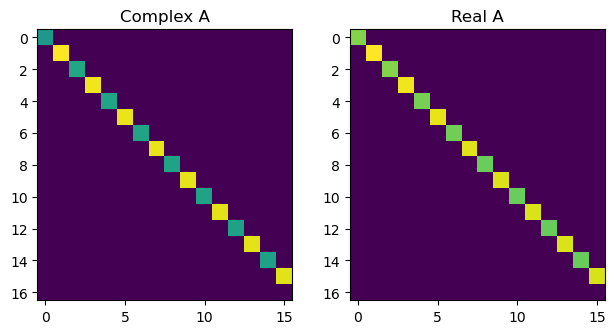

In [4]:
_, h = lanczos_iteration(A, v, N)
# Perform Arnoldi iteration with real A
_, h2 = lanczos_iteration(np.real(A), v, N)

# Plot results
plt.subplot(121)
plt.imshow(np.abs(h))
plt.title("Complex A")
plt.subplot(122)
plt.imshow(np.abs(h2))
plt.title("Real A")
plt.tight_layout()
plt.show()

## QR iteration for Hessenburg matrix to find the eigenvalue decomposition.

In [5]:
def Q_i(Q_min, i, j, k):
    if i < k or j < k:
        return float(i == j)
    else:
        return Q_min[i-k][j-k]

def QR_householder(A):
    n = A.shape[0]

    # Set R equal to A, and create Q as a zero matrix of the same size
    R = A.copy()
    Q = np.zeros((n,n))

    # The Householder procedure
    for k in range(n-1):
        I = np.eye(n)
        x = R[k:,k]
        e = I[k:,k]
        alpha = np.sign(x[0]) * np.linalg.norm(x)

        # Using anonymous functions, we create u and v
        u = np.array(list(map(lambda p,q: p + alpha * q, x, e)))
        print(u)
        norm_u = np.linalg.norm(u)
        v = np.array(list(map(lambda p: p/norm_u, u)))

        # Create the Q minor matrix
        Q_min = np.array([ [float(i==j) - 2.0 * v[i] * v[j] for i in range(n-k)] for j in range(n-k) ])

        # "Pad out" the Q minor matrix with elements from the identity
        Q_t = np.array([[ Q_i(Q_min,i,j,k) for i in range(n)] for j in range(n)])

        if k == 0:
            Q = Q_t
            R = Q_t@A
        else:
            Q = Q_t@Q
            R = Q_t@R

    # Since Q is defined as the product of transposes of Q_t,
    # we need to take the transpose upon returning it
    return Q.T, R

# T2 
Computer problem (in C or C++): Write the functions to achieve Newton’s method and Broyden’s method. Test these methods for a few equation systems.

In [6]:
from scipy import misc
from scipy.optimize import newton

# Newton's Method
def NewtonsMethod(f, x, tolerance=0.000001):
    while True:
        x1 = x - f(x) / misc.derivative(f, x) 
        t = abs(x1 - x)
        if t < tolerance:
            break
        x = x1
    return x

# Broyden’s method
def broyden(x, y, f_equations, J_equations, tol=10e-10, maxIters=50):
    steps_taken = 0
 
    f = f_equations(x,y)
    J = J_equations(x,y)
 
    while np.linalg.norm(f,2) > tol and steps_taken < maxIters:
 
        s = solve(J,-1*f)
 
        x = x + s[0]
        y = y + s[1]
        newf = f_equations(x,y)
        z = newf - f
 
        J = J + (np.outer ((z - np.dot(J,s)),s)) / (np.dot(s,s))
 
        f = newf
        steps_taken += 1
 
    return steps_taken, x, y  

In [7]:
def f(x):
    return (1.0/4.0)*x**3+(3.0/4.0)*x**2-(3.0/2.0)*x-2

x = 4

x_0 = NewtonsMethod(f, x)
x_1 = newton(f, x, fprime=None, args=(), tol=1.48e-08, maxiter=50, fprime2=None)

In [8]:
x_0,x_1

(2.0000002745869883, 2.000000000000008)

In [9]:
tol = 10.0** -15
maxIters = 50
x0 = 1
y0 = 2
 
def fs(x,y):
    return np.array([x + 2*y - 2, x**2 + 4*y**2 - 4])
 
def Js(x,y):
    return np.array([[1,2],
             [2, 16]])
 
n, x, y = broyden(x0, y0, fs, Js, tol, maxIters=50 )
print("iterations: ", n)
print("x and y: ", x, y)

iterations:  8
x and y:  8.159067075518965e-17 0.9999999999999999
